<a href="https://colab.research.google.com/github/VincentStimper/normalizing-flows/blob/master/example/real_nvp_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustration of the usage of the `normflows` package
## Training a Real NVP model

This notebook illustrates how to use the `normflows` packages by training a simple Real NVP model to a 2D distribution consisting on two half moons.

Before we can start, we have to install the package.

In [1]:
!pip install git+https://github.com/telegraphroad/NNF.git

  Cloning https://github.com/telegraphroad/NNF.git to /tmp/pip-req-build-oe1rob2h
  Running command git clone --filter=blob:none --quiet https://github.com/telegraphroad/NNF.git /tmp/pip-req-build-oe1rob2h
  Resolved https://github.com/telegraphroad/NNF.git to commit 2cab7a0a3d1a7745e2e7b5d544844df133ad52a9
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
!which python

/home/samiri/anaconda3/envs/flows/bin/python


In [3]:
# Import required packages
import torch
import numpy as np
import normflows as nf

from sklearn.datasets import make_moons

from matplotlib import pyplot as plt

from tqdm import tqdm

After importing the required packages, we want to create a `nf.NormalizingFlow` model. Therefore, we need a base distribution, which we set to be a Gaussian, and a list of flow layers. The flow layers are simply affine coupling layers, whereby `nf.AffineCouplingBlock` already includes the splitting and merging of the features as it is done in coupling. We also swap the features after each layer to ensure that they are all modified.

In [4]:
# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)
base = nf.distributions.base.GaussianMixture(n_modes = 10, dim = 2, trainable=True)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.NormalizingFlow(base, flows)
bestmodel = nf.NormalizingFlow(base, flows)

In [5]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

This is our target distribution.

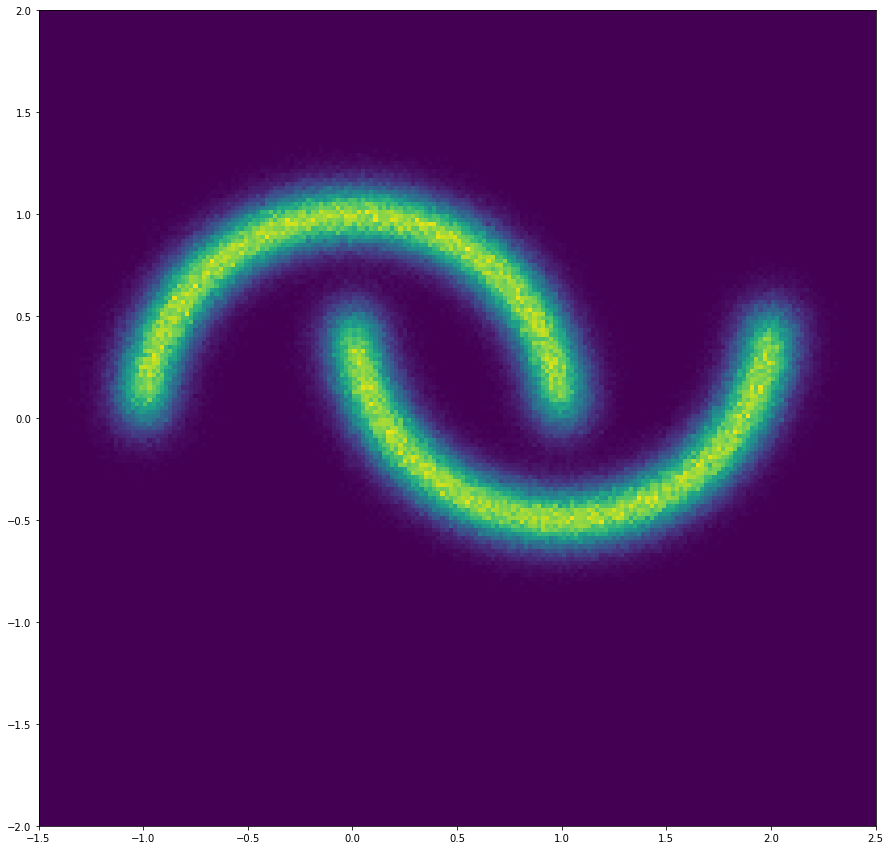

In [6]:
# Plot target distribution
x_np, _ = make_moons(2 ** 20, noise=0.1)
plt.figure(figsize=(15, 15))
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200, range=[[-1.5, 2.5], [-2, 2]])
plt.show()

/home/samiri/anaconda3/envs/flows/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


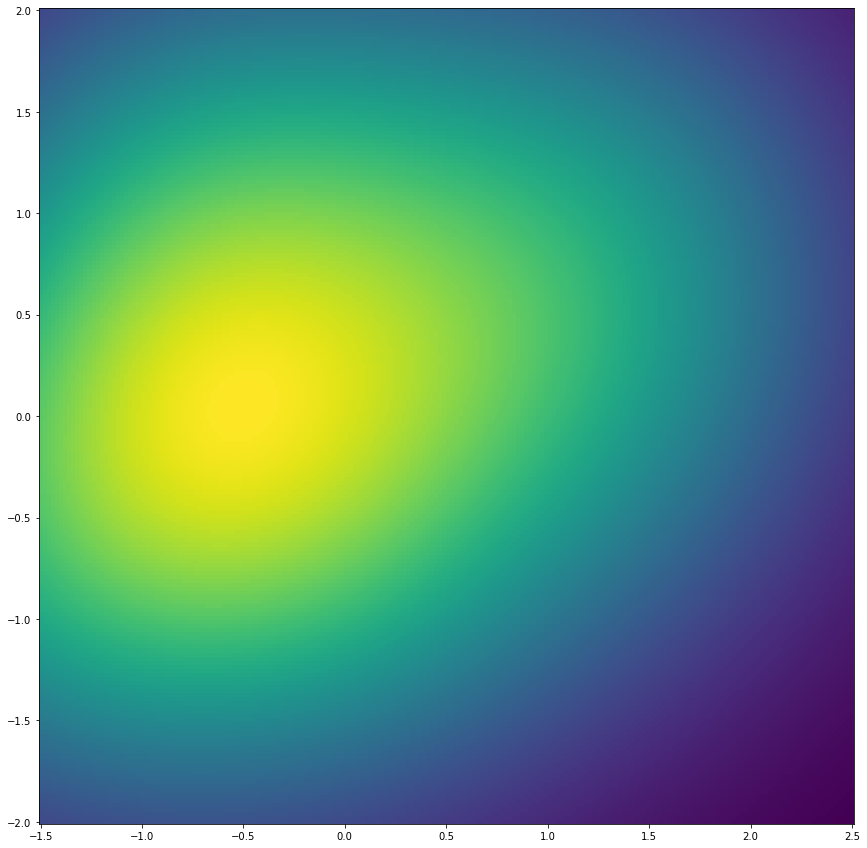

In [7]:
# Plot initial flow distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

Now, we are ready to train the flow model. This can be done in a similar fashion as standard neural networks. Since we use samples from the target for training, we use the forward KL divergence as objective, which is equivalent to maximum likelihood.

 25%|███████████████▏                                             | 499/2000 [00:25<01:15, 19.88it/s]

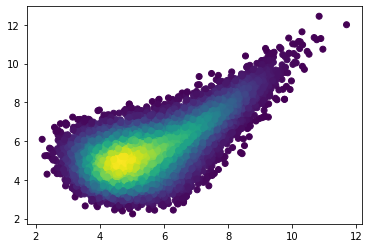

 50%|██████████████████████████████▍                              | 999/2000 [00:50<00:50, 19.87it/s]

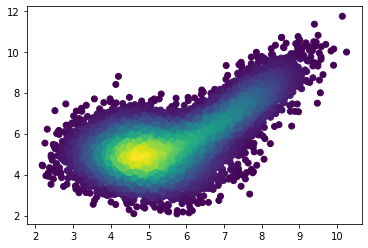

 75%|████████████████████████████████████████████▉               | 1497/2000 [01:16<00:25, 19.84it/s]

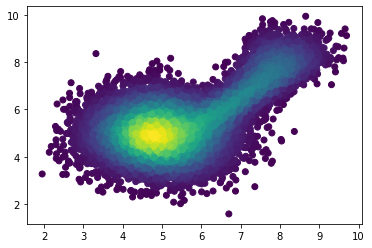

100%|███████████████████████████████████████████████████████████▉| 1997/2000 [01:41<00:00, 19.84it/s]

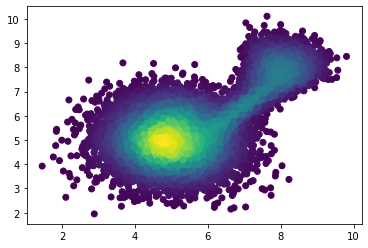

100%|████████████████████████████████████████████████████████████| 2000/2000 [01:41<00:00, 19.61it/s]


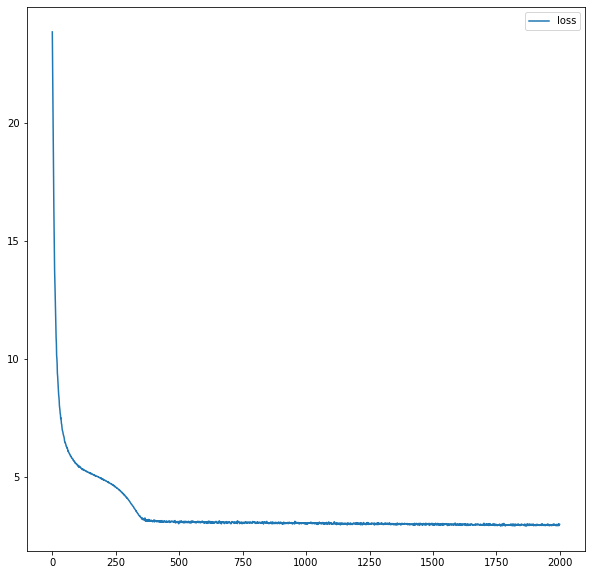

In [8]:
# Train model
max_iter = 2000
num_samples = 2 ** 9
show_iter = 500
import torch.distributions as D
mix = D.Categorical(torch.tensor([1.,.2]))
m = 5.
m2 = 8.
v1 = .9
v2 = .9
v3 = .5
v4 = .5
comp = D.Independent(D.Normal(
             torch.tensor([[m,m],[m2,m2]]), torch.tensor([[v1,v2],[v3,v4]])), 1)
gmm = D.MixtureSameFamily(mix, comp)


loss_hist = np.array([])
bestloss = 9999999999999999999999999.
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
checkpoints = []
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x_np = gmm.sample([2048]).detach().cpu().numpy()
    x = torch.tensor(x_np).float().to(device)
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    if loss.detach().cpu().item() < bestloss:
        bestmodel.state_dict = model.state_dict
        bestloss = loss.detach().cpu().item()
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        checkpoints.append(model.state_dict)
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        # plt.figure(figsize=(15, 15)) 
        # plt.pcolormesh(xx, yy, prob.data.numpy())
        # plt.gca().set_aspect('equal', 'box')
        # plt.show()
        plt.plot()
        a = model.sample(10000)[0].detach().cpu().numpy()
        colors = model.log_prob(torch.tensor(a).cuda()).exp().detach().cpu().numpy()  

        plt.scatter(a[:,0],a[:,1],c=colors)
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

This is our trained flow model!

Note that there might be a density filament connecting the two modes, which is due to an architectural limitation of normalizing flows, especially prominent in Real NVP. You can find out more about it in [this paper](https://proceedings.mlr.press/v151/stimper22a).

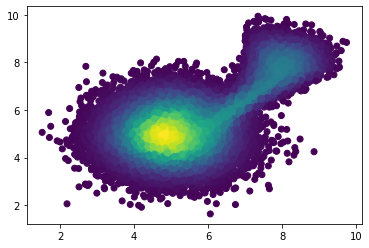

In [9]:
a = bestmodel.sample(20000)[0].detach().cpu().numpy()
colors = bestmodel.log_prob(torch.tensor(a).cuda()).exp().detach().cpu().numpy()  

plt.scatter(a[:,0],a[:,1],c=colors)
plt.show()


/tmp/ipykernel_5431/1483894161.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smpl = torch.tensor(m2.sample([1000])).cuda()


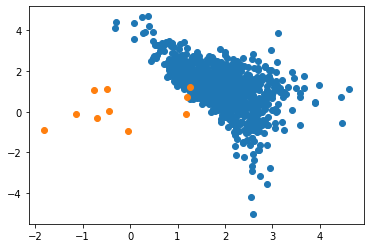

In [10]:
m2 = D.Normal(loc=torch.tensor([8.,8.]),scale=torch.tensor([0.5,0.5]))
smpl = torch.tensor(m2.sample([1000])).cuda()

z,l = bestmodel.forward_kld(smpl,extended=True)
z = z.cpu().detach().numpy()
plt.scatter(z[:,0],z[:,1])
means = model.q0.loc.squeeze().cpu().detach().numpy()
covs = model.q0.log_scale.exp().squeeze().cpu().detach().numpy()
plt.scatter(means[:,0],means[:,1])
#plt.scatter(covs[:,0],covs[:,1],color='red')


In [20]:
m2 = D.Normal(loc=torch.tensor([1.23460046,  3.14016754]),scale=torch.tensor([0.98325083, 0.92464903]))

smpl = torch.tensor(m2.sample([1000])).float().cuda()
lp = m2.log_prob(smpl.cpu()).cuda()
#bestmodel.q0 = m2
z= model.backward(1000,z=smpl,log_q_=lp).cpu().detach().numpy()
z

================ torch.Size([1000, 2])


/tmp/ipykernel_5431/1927176544.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smpl = torch.tensor(m2.sample([1000])).float().cuda()


RuntimeError: The size of tensor a (2) must match the size of tensor b (1000) at non-singleton dimension 1

In [ ]:
# Plot learned posterior distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()